In [ ]:
# install mlxtend if you haven't already

# ! conda install -y mlxtend

In [2]:
#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################
import pandas as pd
import numpy as np
import seaborn as sns

import itertools
import pickle
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!


from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.datasets.california_housing import fetch_california_housing


sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


# Bagging

**Bootstrap aggregating**, more commonly referred to as **bagging**, is a type of machine learning algorithm that is designed to improve the accuracy and stability of the model. We will discuss bootstrapping and aggregating below, but we'll first outline the algorithm itself.

The Bagging algorithm is fairly simple:

Given a training set $T = \{(x_1, y_1), \ldots, (x_n, y_n)\}$

- Sample $k$ sets of $n$ elements from $T$ (with replacement), giving sets $T_1, \ldots, T_k$
- Train an algorithm on each $T_i, i=1, \ldots, k$ and obtain a sequence of $k$ outputs $f_1(\mathbf{x}), \ldots, f_k(\mathbf{x})$


The final aggregate classifier is:

**for Regression** - take the average of all of the predictions
$$\bar{f}(\mathbf{x}) = \frac{1}{k} \sum_{i=1}^k f_i(\mathbf{x})$$

**for Classification** there are a few options, which are covered in more depth later in this lesson including:
- Average Voting
- Max Voting




Here is a nice visual representation of the bagging algorithm

![](images/bagging.jpg)

## Bootstrapping

Bootstrapping is a sampling technique. Out of the $n$ samples in our dataset, $k$ samples are chosen **with replacement**. 

We'll use income data to see how this works in action

In [3]:
df = pd.read_csv('data/incomes.csv')
incomes = df['income'].values

In [4]:
def get_random_indices(num):
    return np.random.randint(0, num, num)

def get_random_sample(X):
    indices = get_random_indices(len(X))
    return X[indices]

def get_sample_median(X):
    sample = get_random_sample(X)
    return np.median(sample)

In [5]:
medians = [get_sample_median(incomes) for _ in range(200)]

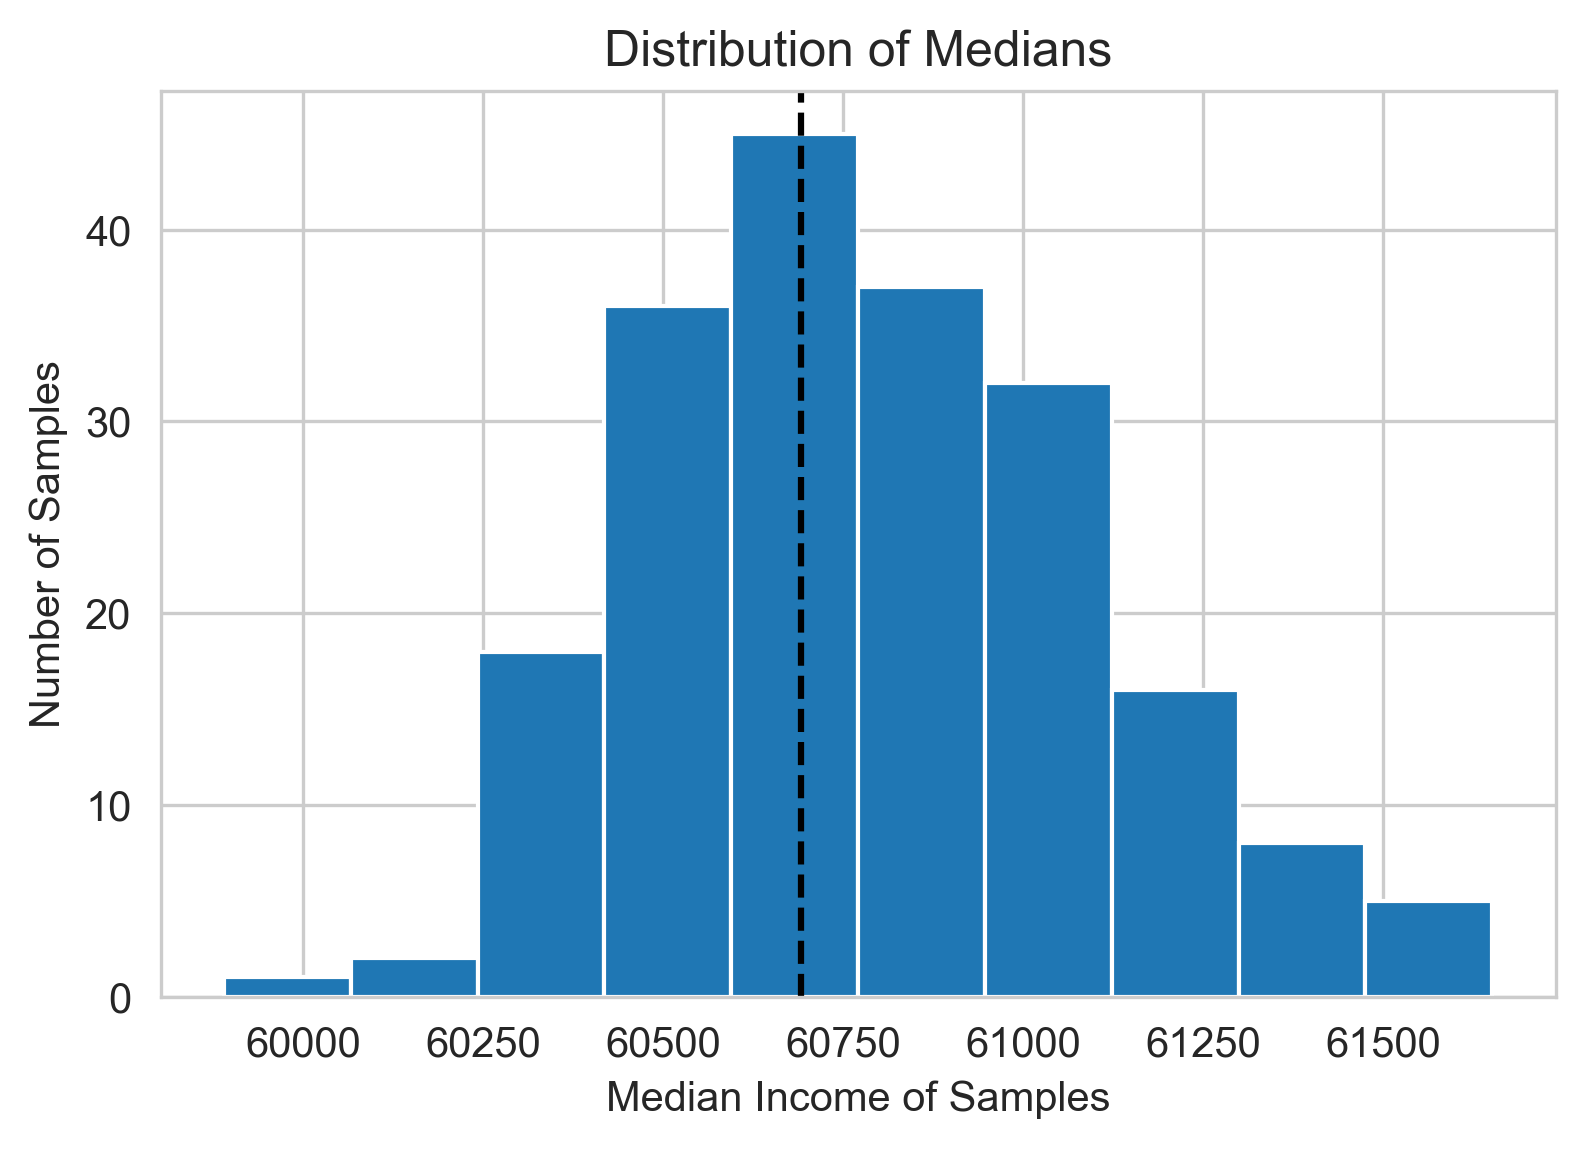

In [6]:
plt.figure(dpi=150)
plt.hist(medians)
plt.title('Distribution of Medians')
plt.xlabel('Median Income of Samples')
plt.ylabel('Number of Samples')

# Plot real median value
whole_sample_median = np.median(incomes)
plt.gca().axvline(whole_sample_median, ls='--', c='k');

When we get a dataset to build a machine learning model, we can only say what the sample median is for this dataset, but not necessarily what the true population median is. In other words, our sample median may be different from the true population median and we need a way to look at many different subsets to generalize. This is what we calculated in the figure above. 

What happens if we don't bootstrap? Well, it's probable that we can get a biased sample that will fail to generalize, i.e., we will overfit our model. 

As with any statistical sampling method, we prefer to look at the *distribution* of our feature and find a 95% likelihood cut-off.

In [7]:
# What are the percentiles? This gives us a range of values 
# that the sample median lies in 95% of the samples
np.percentile(medians,2.5), np.percentile(medians, 97.5)

(60271.5, 61473.95)

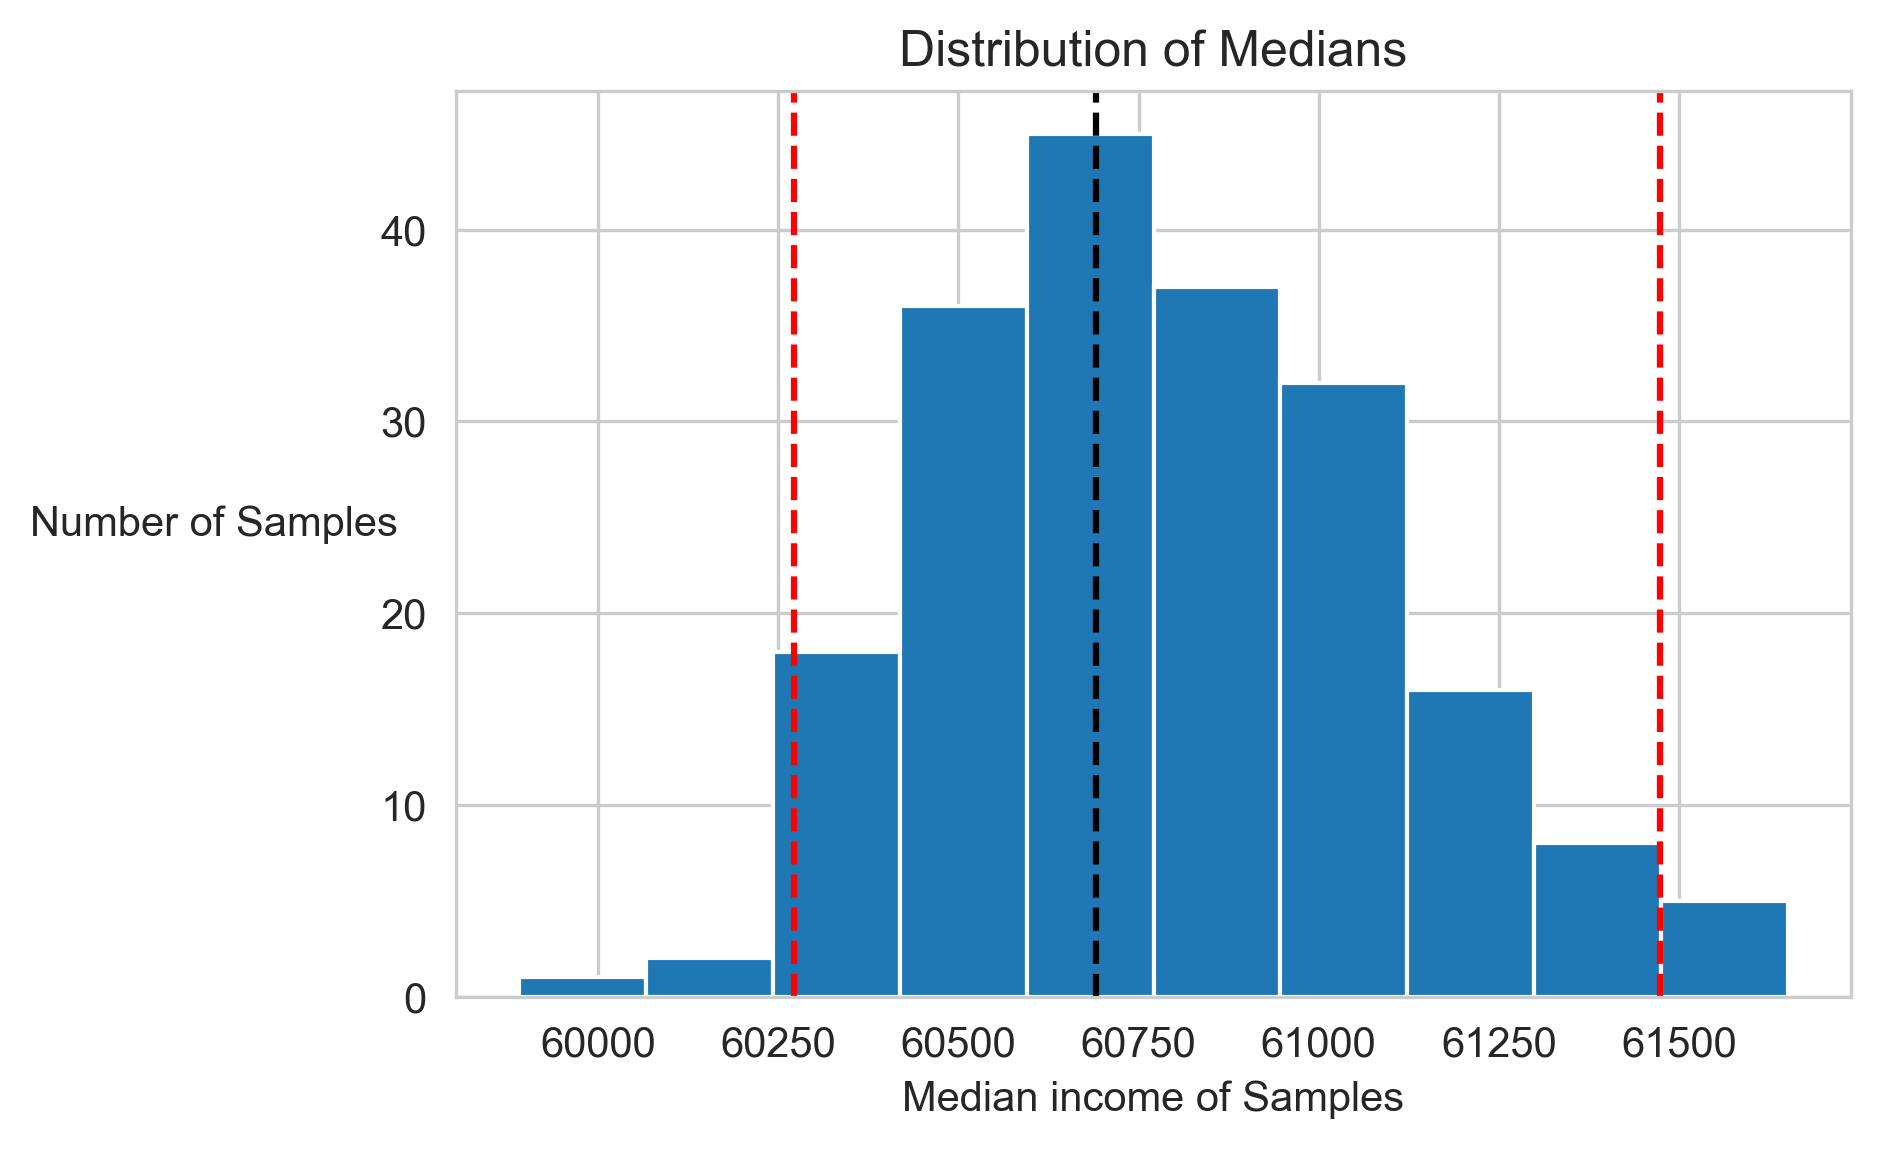

In [11]:
plt.figure(dpi=150)
plt.hist(medians)
plt.title('Distribution of Medians')
plt.xlabel('Median income of Samples')
plt.ylabel('Number of Samples',rotation=0,labelpad=40)

lower, upper = np.percentile(medians, 2.5), np.percentile(medians, 97.5)
plt.gca().axvline(whole_sample_median, ls='--', c='k')
plt.gca().axvline(lower, ls='--', c='r')
plt.gca().axvline(upper, ls='--', c='r');

In [9]:
# How many unique samples do we have from our original dataset?

unique_samples = []
for i in range(500):
    uniques = len(np.unique(get_random_indices(len(incomes))))
    unique_samples.append(uniques)

As the number of observations in our dataset increases, our **bootstrapping method will select $\approx (1 - 1/e)$ unique samples.** The derivation is beyond the scope of this lesson, but can be found in the resources at the end of this notebook.

In [10]:
# verify statement above
(1 - 1/np.exp(1))*len(incomes), np.mean(unique_samples)

(1190.9151328330026, 1191.952)

# Aggregating

Recall from an earlier lesson that Decision Trees are **prone to high variance.** (if you build a big tree, any change in a feature will lead you down a very different path).  
  
In other words, they will find complex & nonlinear ways to get the highest accuracy from the data, but it comes at the cost of overfitting to the training set. This is why decision trees aren't popular in practice and instead data scientists use an __*ensemble* of decision trees__ instead to address this. 

**Note:** an ensemble of decision trees is called a **Random Forest.**


## Why ensemble?

Because **bagging reduces variance**

The intuition is the following:

If each single classifier is unstable - that is, it has **high
variance** like decision trees - the aggregated classifier $\bar f$ has a smaller variance than a single original classifier.

This is because the aggregated classifier $\bar f$ can be thought of as an approximation to the true (i.e. population) average obtained by replacing the probability distribution $p$ in the data with the bootstrapped approximations to $p$ obtained by concentrating mass $1/n$ at each point $(x_i, y_i)$.

In short, looking at bootstrapped samples and running several different models on the data allows the classifier to find the best aggregate model that will generalize best to our data.

Let's see this in action using the California Housing data.

In [12]:
data = fetch_california_housing()

In [13]:
X = data.data
y = data.target

In [19]:
# They're not doing CV here but you HAVE TO DO IT MATE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [21]:
# confirm our model is overfitting
dt_model = DecisionTreeRegressor(random_state=123)
dt_model.fit(X_train, y_train)
print(f'Train R^2 Score: {np.round(dt_model.score(X_train, y_train), 4)}')  # Model performs really well on train

# Model performs like shit on test. 
# This is a huge indicator of overfitting
print(f'Test R^2 Score: {np.round(dt_model.score(X_test, y_test), 4)}')  

print("\nThe tree was used with it's default parameters, and you can see that it already overfits the data.")

Train R^2 Score: 1.0
Test R^2 Score: 0.5906

The tree was used with it's default parameters, and you can see that it already overfits the data.


In [16]:
def bias_metric(y_true, y_pred):
    return np.mean((np.mean(y_pred) - y_true)**2)

def variance_metric(y_true, y_pred):
    return np.var(y_true - y_pred)

In [17]:
# Run bagging classifier through cross validation
# ~45s to run
# instructor: pull up the bagging classifier docs if useful
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

variance = []
bias = []
test_range = np.arange(1, 30, 1)

for i in test_range:  # test_range is from 1-29
    cv_out = cross_validate(
        estimator=BaggingRegressor(
            DecisionTreeRegressor(random_state=123), n_estimators=i),
        X=X_train,
        y=y_train,
        cv=3,
        return_train_score=True,
        scoring={
            "variance": make_scorer(variance_metric),
            "bias": make_scorer(bias_metric)
        },
        n_jobs=-1,
    )
    variance.append(np.mean(cv_out['test_variance']))
    bias.append(np.mean(cv_out['test_bias']))

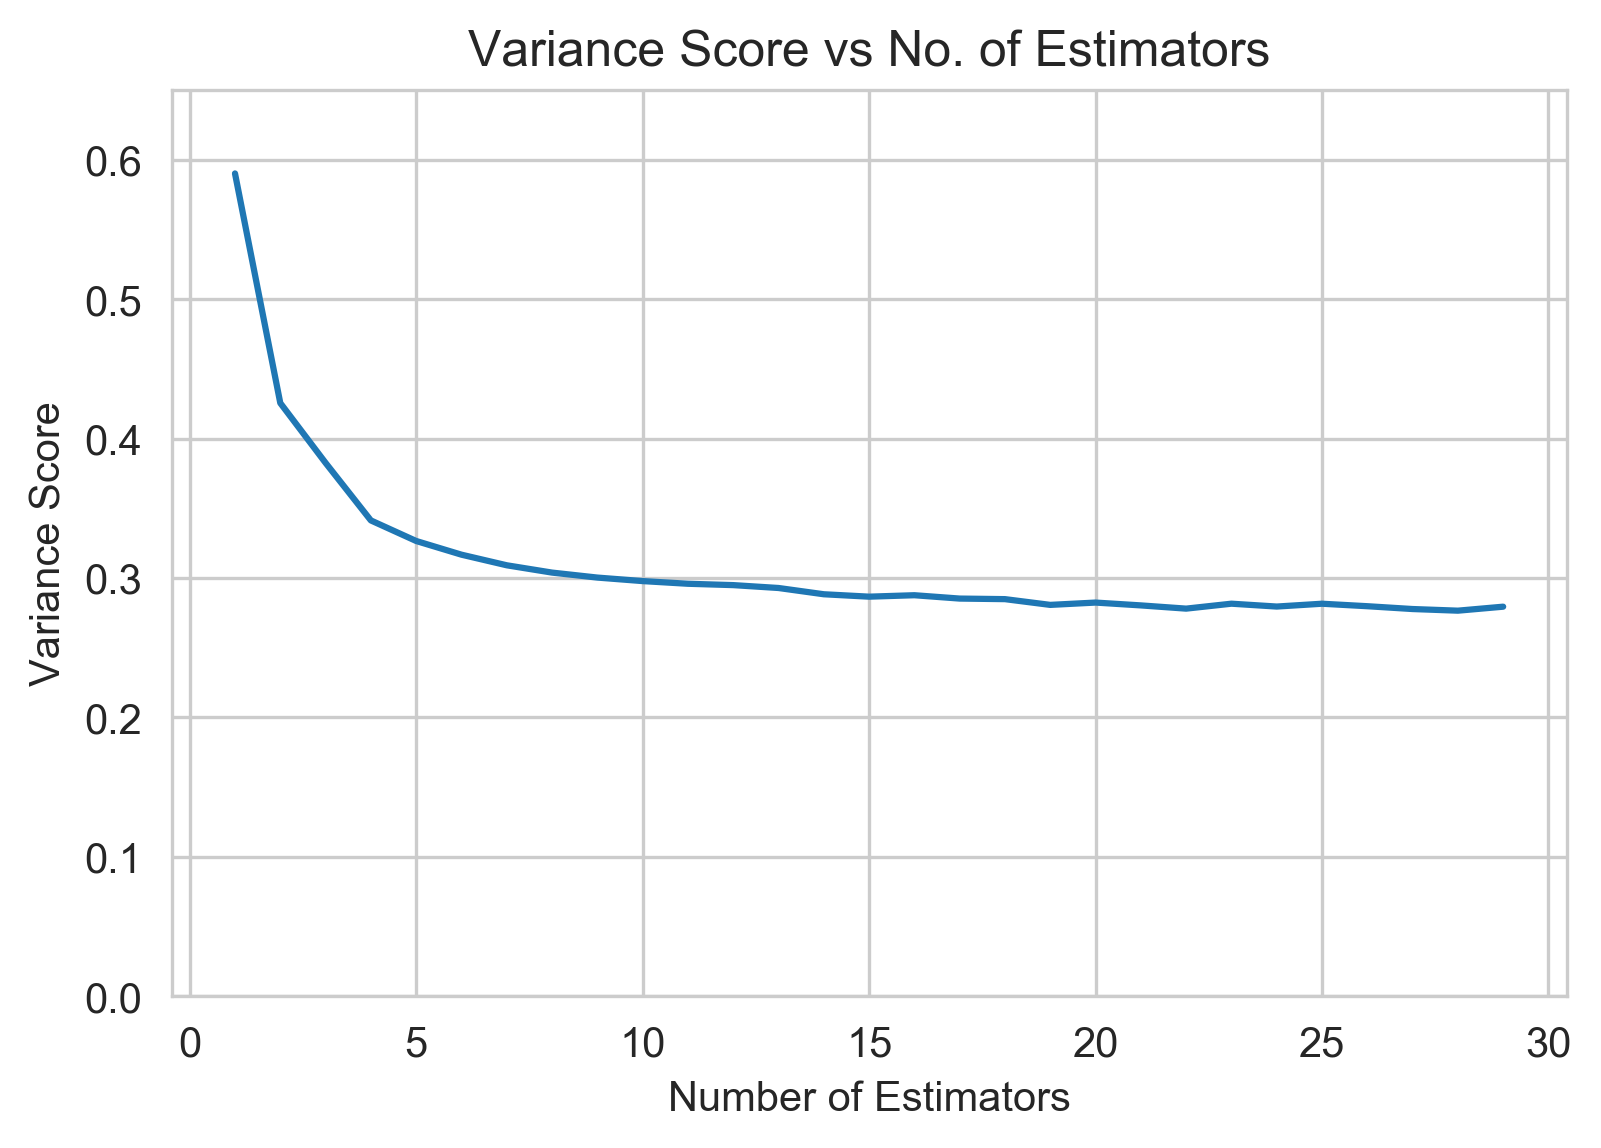

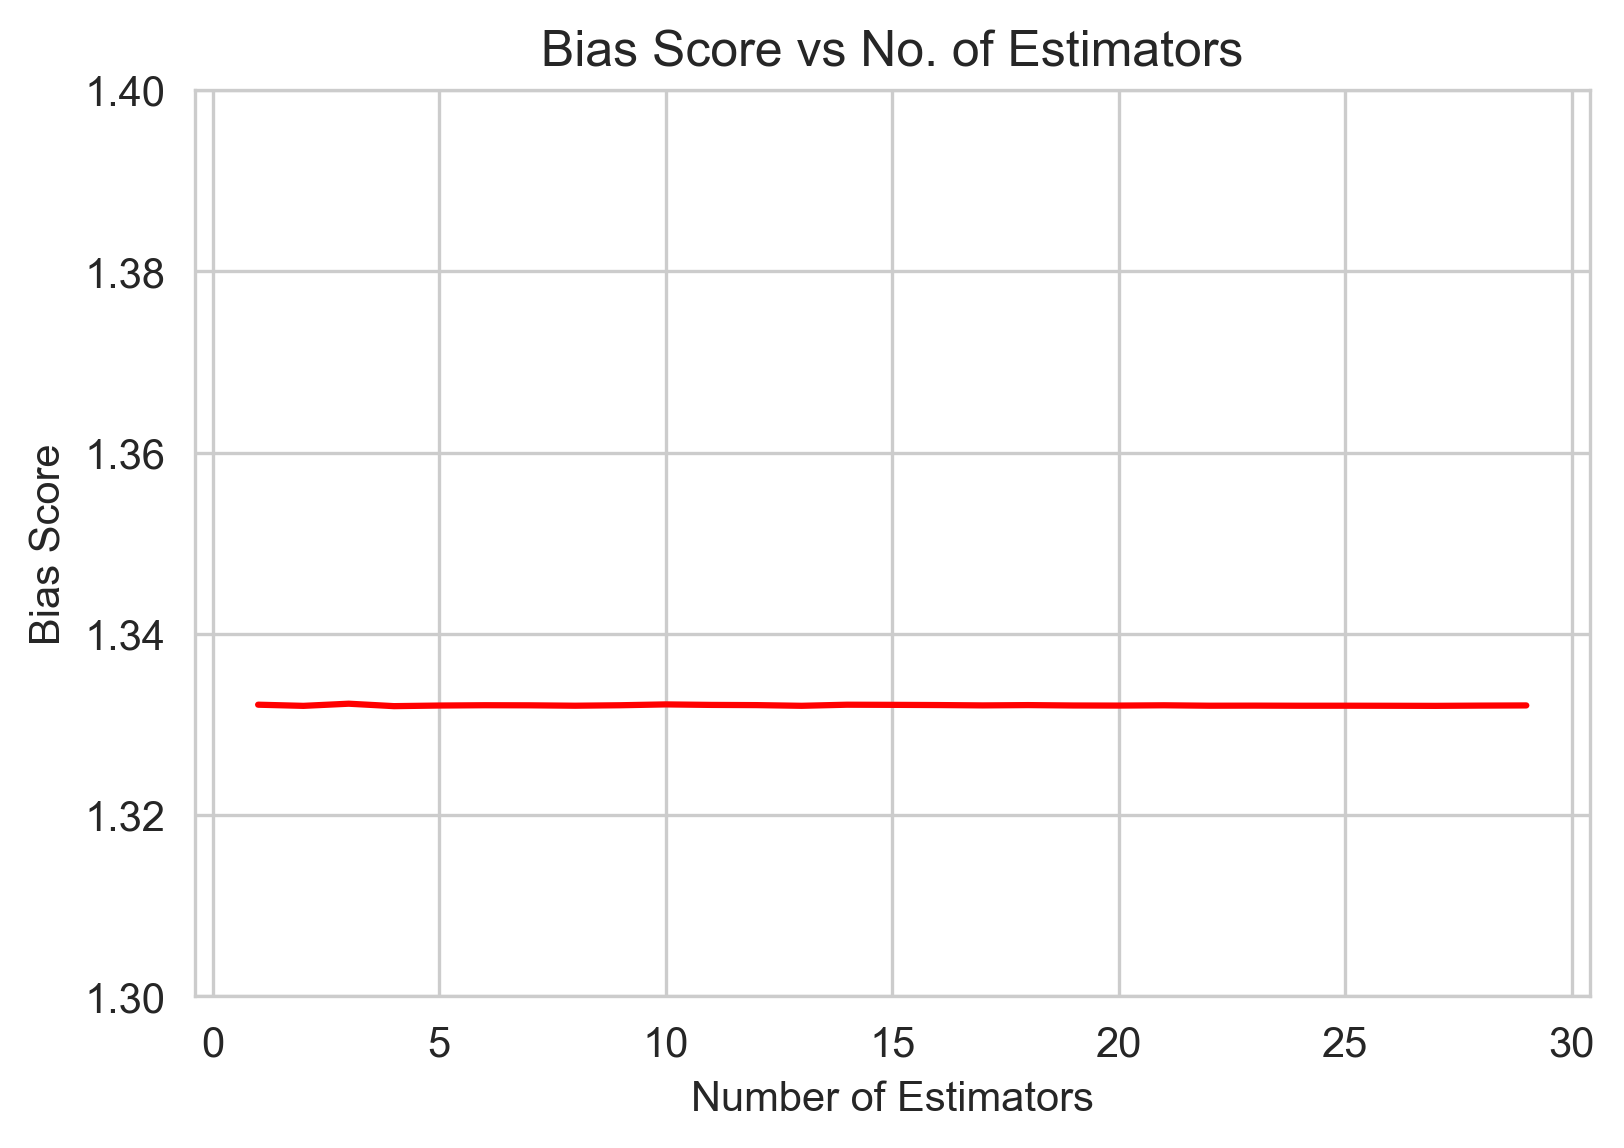

In [18]:
plt.figure(dpi=150)
plt.plot(test_range, variance, label='variance')
plt.ylim((0, 0.65))
plt.xlabel('Number of Estimators')
plt.ylabel('Variance Score');
plt.title('Variance Score vs No. of Estimators');

plt.figure(dpi=150)
plt.plot(test_range, bias, label='bias', c='r')
plt.ylim((1.3, 1.4))
plt.xlabel('Number of Estimators')
plt.ylabel('Bias Score');
plt.title('Bias Score vs No. of Estimators');

From the graph above, we can see there is a clear **reduction in the variance** when **increasing the number of estimators**.

# Ensemble Methods

In the previous section we talked about Bagging and how it reduces variance. But there are many more types of ensemble models. The Bagging classifier, allows us to look at the same data through the lens of many bootstrapped samples... But, we're only able to use one classifier to train each bootstrapped sample.

This begs the question: **Can we apply the same logic from bagging to use not just one model, but many different kinds of models as well?**

Fortunately, the answer is **yes** and this section will provide how we can use this "best-of-breed" approach to build different ensemble models.

# Intuition

Before we dive into the nitty-gritty we'll use an analogy to drive what we want to achieve from our ensemble model.

There is an old parable, called "The Blind Men and the Elephant" [wikipedia](https://en.wikipedia.org/wiki/Blind_men_and_an_elephant).

The gist is the following:

> A group of blind men have never seen an elephant before. They all are curious to learn what the elephant is like, so each blind man feels a different part of the elephant's body, but only one part, such as the side or the tusk. They then describe the elephant based on their limited experience and their descriptions of the elephant are different from each other.

Sounds pretty similar to what data scientists do!

![](images/elephant.jpeg)

We can think of **each blind man as an individual "model"** that comes with certain biases and different decision as to what the elephant is like. Fortunately, we don't have to take the recommendation of one model only, we can take all of those recommendations ourselves and decide what makes up an elephant.

This is, in essence, what any ensemble model is trying to do. It will look at all of the recommendations from different kinds of models and then make a decision based on the aggregate of all of the responses.

# Voting Classifier

One of the most common ensemble models is the Voting Classifier. It does what its name implies, looks at the votes of the pre-trained algorithms and gives an output.

<img src="images/ensemble.png" alt="" width="500" height="600"/>

There are 3 different flavors for voting classifier which we will discuss.

- Max Voting
- Average Voting
- Weighted Voting

But, before we get into all the fun stuff, let's load some data and pre-trained models.

In [23]:
df = pd.read_csv('data/dataframe.csv')

In [24]:
pal = dict(enumerate(sns.color_palette("colorblind", 2)))

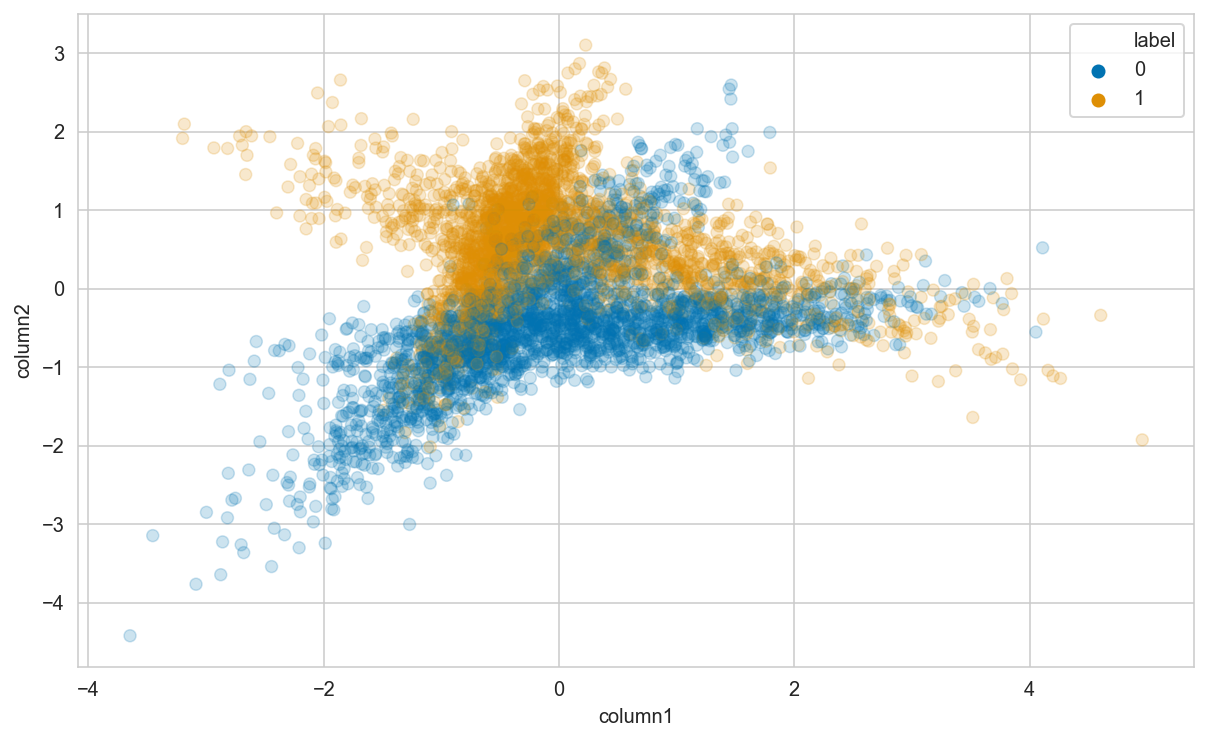

In [25]:
sns.scatterplot('column1', 'column2', data=df, hue='label',
           palette=pal, alpha=.2, edgecolor=None)
plt.gcf().set_size_inches(10,6);

This dataset is hard to classify, and each model may not be able to do it well. However, a combination of models may be able to give you a better picture of a prediction!!

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df.label, random_state=123)

In [27]:
# Load pre-trained/tuned models

model_names = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model"]

for model_name in model_names:
    with open(f"models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [28]:
# Quick peek at each model performance

for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

lr_model score: 0.7976
nb_model score: 0.7936
knn_model score: 0.8112
svc_model score: 0.84
rf_model score: 0.8104
et_model score: 0.8016
ada_model score: 0.816


## Max Voting

The basic assumption for the max voting algorithm is easy: Take the class that has the largest number of predictions for each model.

**Classifier 1 -> Class 0**

**Classifier 2 -> Class 1**

**Classifier 3 -> Class 1**

In the example above, our max voting method would choose class 1.

One item to be aware of is what happens with ties. Say we had the following outputs:

**Classifier 1 -> Class 0**

**Classifier 2 -> Class 1**

**Classifier 3 -> Class 1**

**Classifier 4 -> Class 0**


In this scenario, the max voting method chooses class 0 since the algorithm breaks the tie by looking at the output from the **last** classifier (sorted alphabetically by name).

### Visualize output from each model

Looking at decision regions will help us solidify how the algorithm is working.

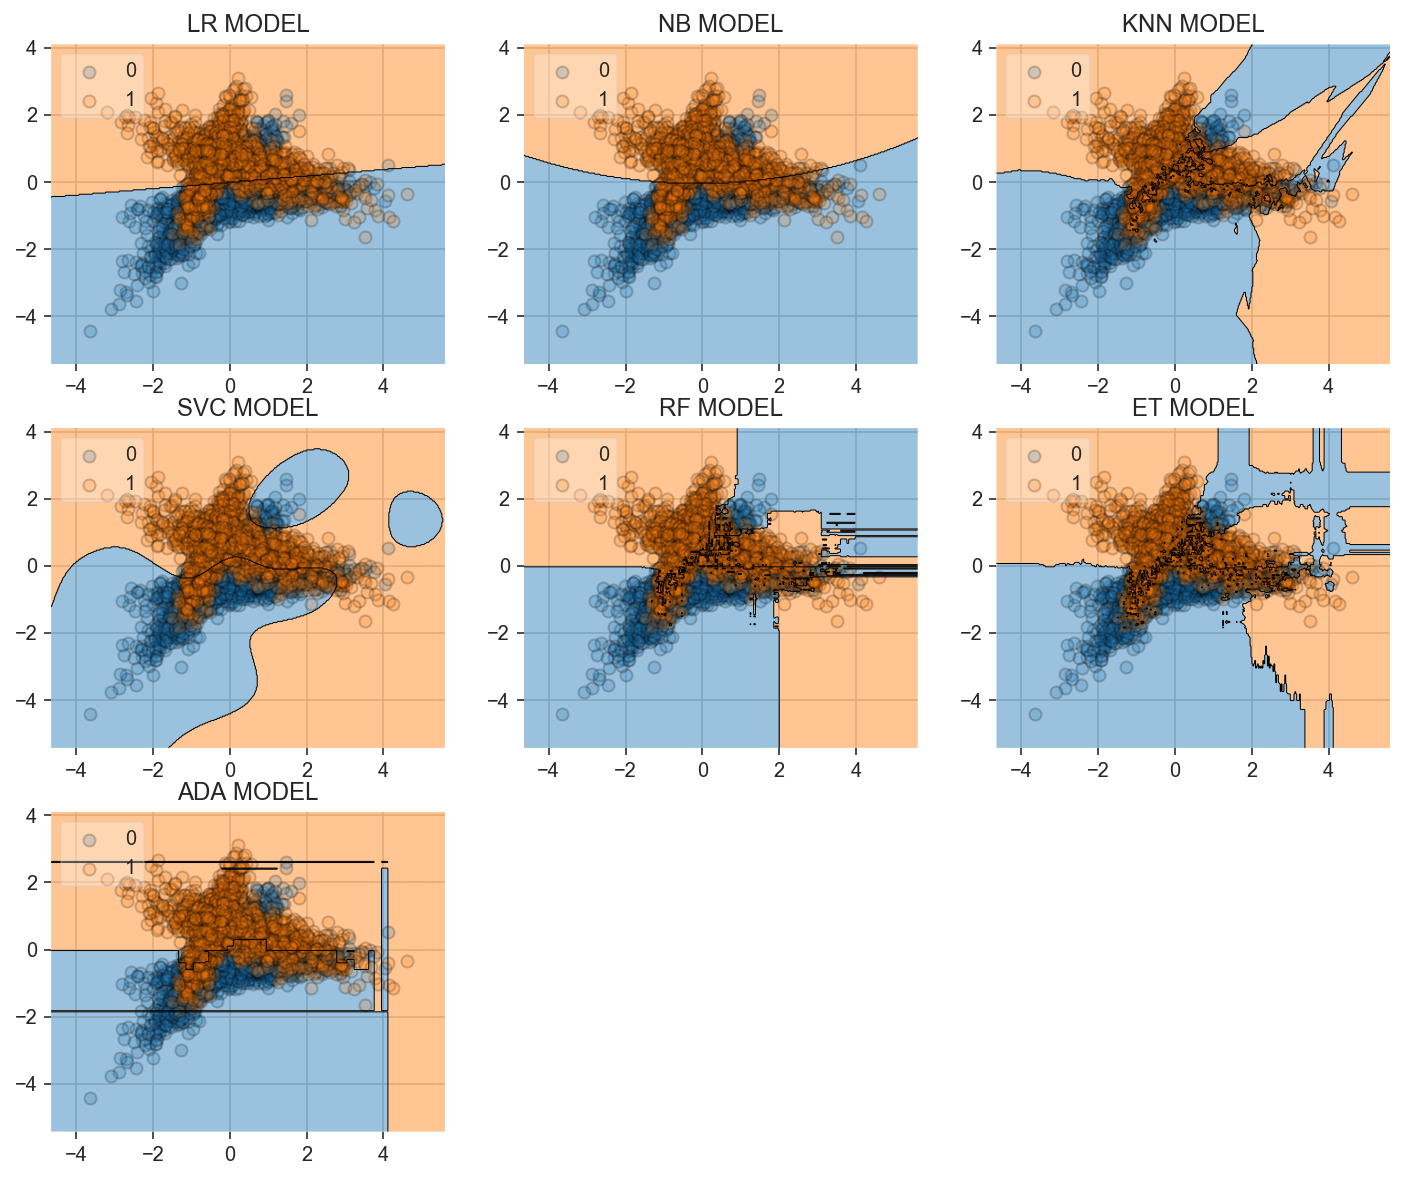

In [30]:
# Plot decision region for each model.
gs = GridSpec(3, 3)
for model_name, grd_i in zip(model_names, itertools.product([0, 1, 2], repeat=2)):

    clf = eval(model_name)

    ax = plt.subplot(gs[grd_i[0], grd_i[1]])
    fig = plot_decision_regions(
        X=X_train.values,
        y=y_train.values,
        clf=clf,
        legend=2,
        markers="o",
        scatter_kwargs=dict(c=list(pal.values()), alpha=.2, edgecolors="none"),
        contourf_kwargs=dict(colors=list(pal.values())))
    ax.set_title(model_name.replace('_', ' ').upper())

plt.gcf().set_size_inches(12, 10)
plt.show()

Let's put our knowledge of the max voting method to use. 

**Focusing only in the square in the lower right corner, what prediction do we expect our model to give us for the ensemble classifier?**

**Answer**: Looking at the output from each of the models, we have two models predicting class 0 (Log Reg and Naive Bayes) and the other five models predicting class 1. 

Thus, our model should **predict class 1** as it has more votes.

Let's verify that this is indeed the case by running our ensemble classifier.

In [31]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting (don't care if it's 0.5. If it's 0.5, will consider as 1)
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb_model',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('knn_model',
                              KN...
                                                   min_impurity_split=None,
          

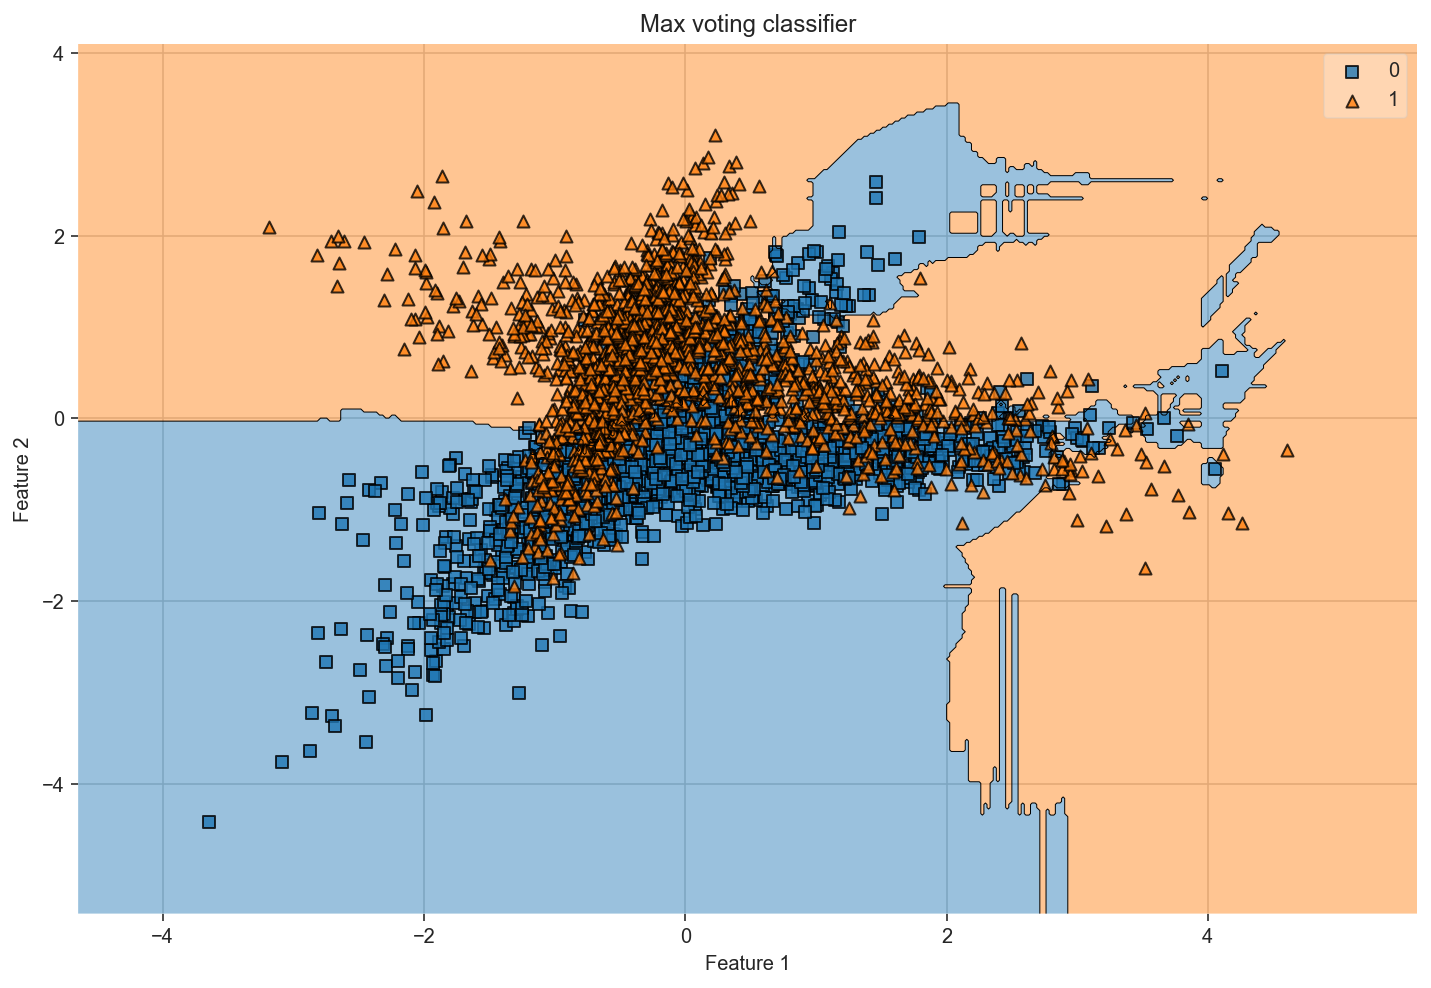

In [32]:
# Plot model
plot_decision_regions(X_train.values, y_train.values, voting_classifer)
plt.title('Max voting classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

**Et voilà!**

Our ensemble classifier chose class 1 for our lower right corner, just like we expected.


Like any other model in `sklearn` we can see how our ensemble model performing on the test data. Ideally, we'd like to beat our best performing individual model, but this is **not** always guaranteed to happen.  
  
**(No Free Lunch Theorem)**  
While this sounds good in theory, it may not be as good as JUST ONE model. The thing is, you will never know. You just gotta put in the work and try.


In [33]:
# Get accuracy (model to beat: SVC with 0.8456 accuracy)
y_pred = voting_classifer.predict(X_test)
accuracy_score(y_test, y_pred)

0.8296

Not an improvement, but our ensemble classifier would be tied for 2nd place out of all of our models.

## Average Voting

In average voting (aka soft voting), we predict the class labels based on the predicted probabilities $p$ for classifier.

Ultimately, the algorithm will decide which class has the highest sum of probabilities, i.e.,

$$\hat{y} = \arg \max_i \sum_{j=1}^k p_{ij}$$

where $i$ is the number of classes and $k$ is the number of models.



In our example we are looking at a binary classification task with class labels $i \in \{0,1\}$. Imagine our ensemble is making the following predictions:

- $\mathbf{C}_1(\mathbf{x}) \rightarrow [0.9, 0.1]$ 
- $\mathbf{C}_2(\mathbf{x}) \rightarrow [0.8, 0.2]$
- $\mathbf{C}_3(\mathbf{x}) \rightarrow [0.4, 0.6]$ 



Using uniform weights, the average probabilities are the following:

$$p(i_0 | \mathbf{x}) = \frac{0.9 + 0.8 + 0.4}{3} = 0.7 $$

$$p(i_1 | \mathbf{x}) = \frac{0.1 + 0.2 + 0.6}{3} = 0.3 $$

$$\hat y = \arg \max_i [p(i_0 | \mathbf{x}), p(i_1 | \mathbf{x})] = 0 $$

In [34]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb_model',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('knn_model',
                              KN...
                                                   min_impurity_split=None,
          

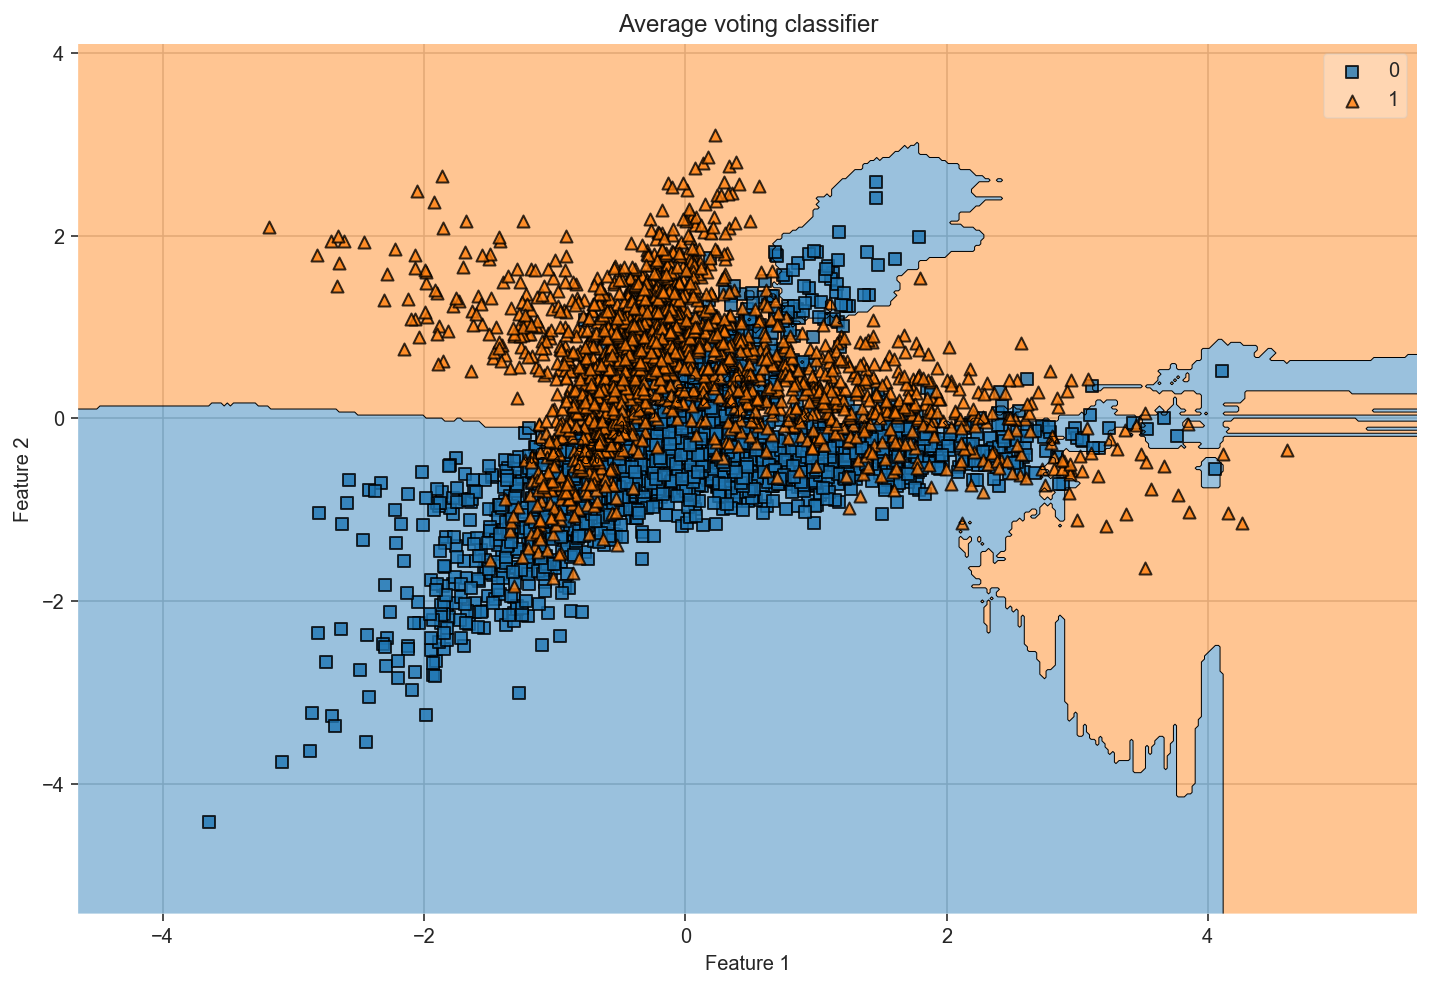

In [35]:
# Plot model
plot_decision_regions(X_train.values, y_train.values, voting_classifer)
plt.title('Average voting classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

Note that our decision regions have changed! 

In [36]:
# Get accuracy (model to beat: SVC with 0.8456 accuracy)
y_pred = voting_classifer.predict(X_test)
accuracy_score(y_test, y_pred)

0.8288

Still no improvement...

# Weighted Voting

As the name implies, we'll be assigning weights to each model to adjust its contribution to the final prediction. There will be times when you want to give additional weight to models that are performing better to increase the optimization metric.

Mathematically speaking, there is very little change to the Average Voting method we just saw. All we do is add a weight to each probability, i.e.,

$$\hat{y} = \arg \max_i \sum_{j=1}^k w_j p_{ij}$$

where $i$ is the number of classes, $w_j$ is the model weight, and $k$ is the number of models.


Imagine our ensemble is making the same predictions as before:

- $\mathbf{C}_1(\mathbf{x}) \rightarrow [0.9, 0.1]$ 
- $\mathbf{C}_2(\mathbf{x}) \rightarrow [0.8, 0.2]$
- $\mathbf{C}_3(\mathbf{x}) \rightarrow [0.4, 0.6]$ 



Using weights for each model with value $\{0.1, 0.1, 0.8\}$, the results are the following:

$$p(i_0 | \mathbf{x}) = 0.1*0.9 + 0.1*0.8 + 0.8*0.4 = 0.49 $$

$$p(i_1 | \mathbf{x}) = 0.1*0.1 + 0.1*0.2 + 0.8*0.6 = 0.51 $$

$$\hat y = \arg \max_i [p(i_0 | \mathbf{x}), p(i_1 | \mathbf{x})] = 1 $$

In [37]:
# create voting classifier
weights = [1.5,2.3,3.8,4.2,4.2,2.2,1.1]
voting_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    weights = weights,
                                    n_jobs=-1)
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('nb_model',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('knn_model',
                              KN...
                                                   min_samples_split=2,
              

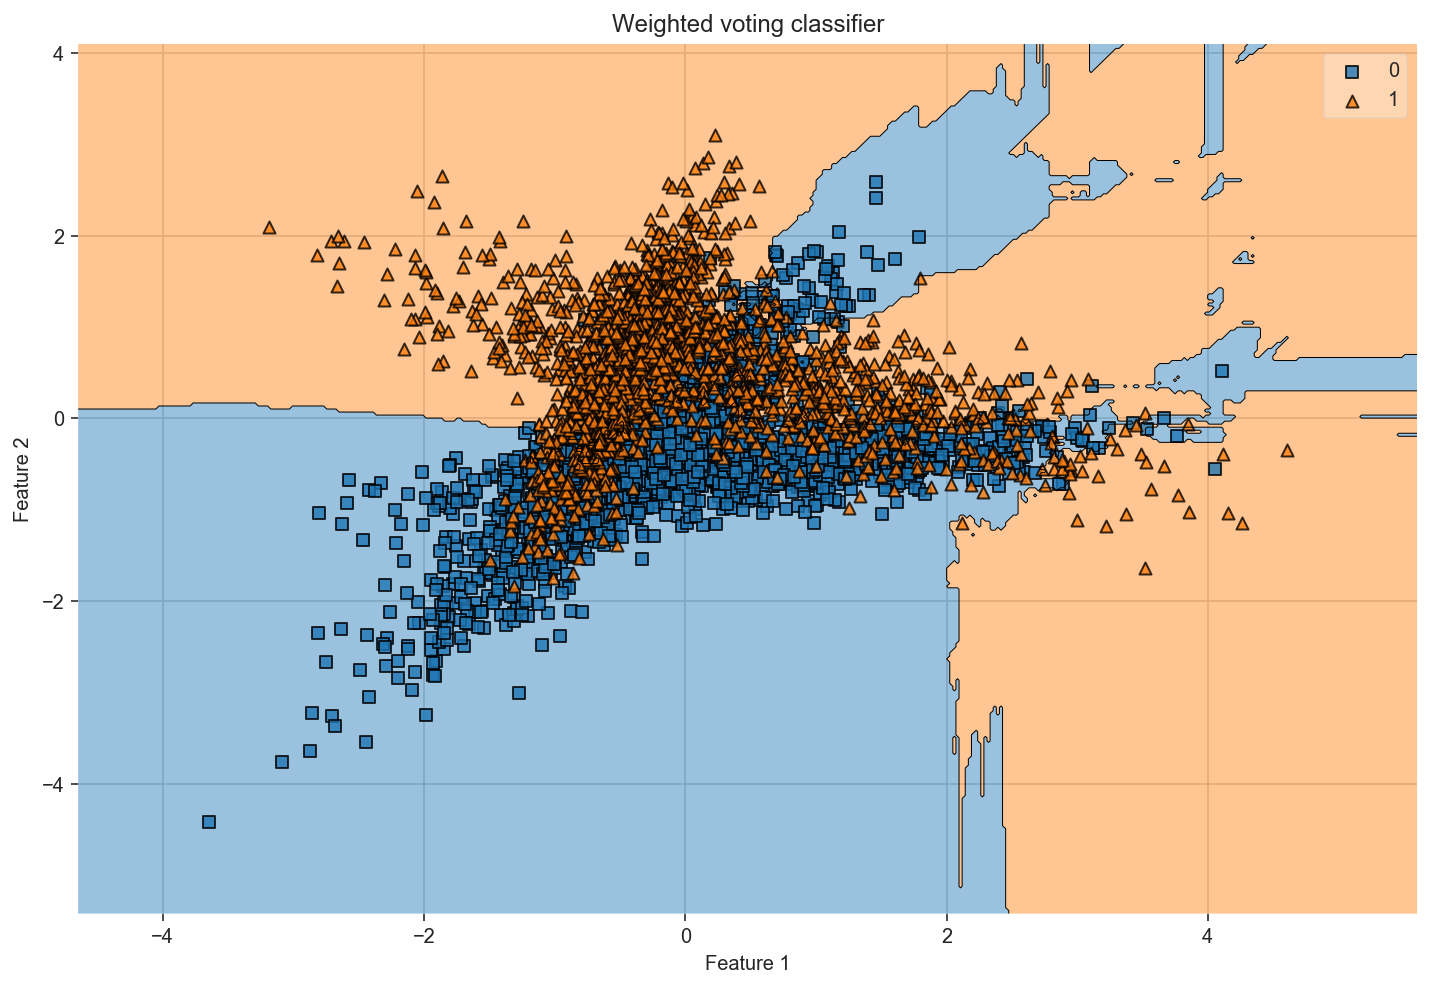

In [38]:
# Plot model
plot_decision_regions(X_train.values, y_train.values, voting_model)
plt.title('Weighted voting classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [39]:
# Get accuracy (model to beat: SVC with 0.8456 accuracy)
y_pred = voting_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8312

## Visualizing the Weighted Voting System

In [40]:
# predict class probabilities for all classifiers
probas = [c.predict_proba(X_train) for n,c in model_list]
probas += [voting_model.predict_proba(X_train)]

In [41]:
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

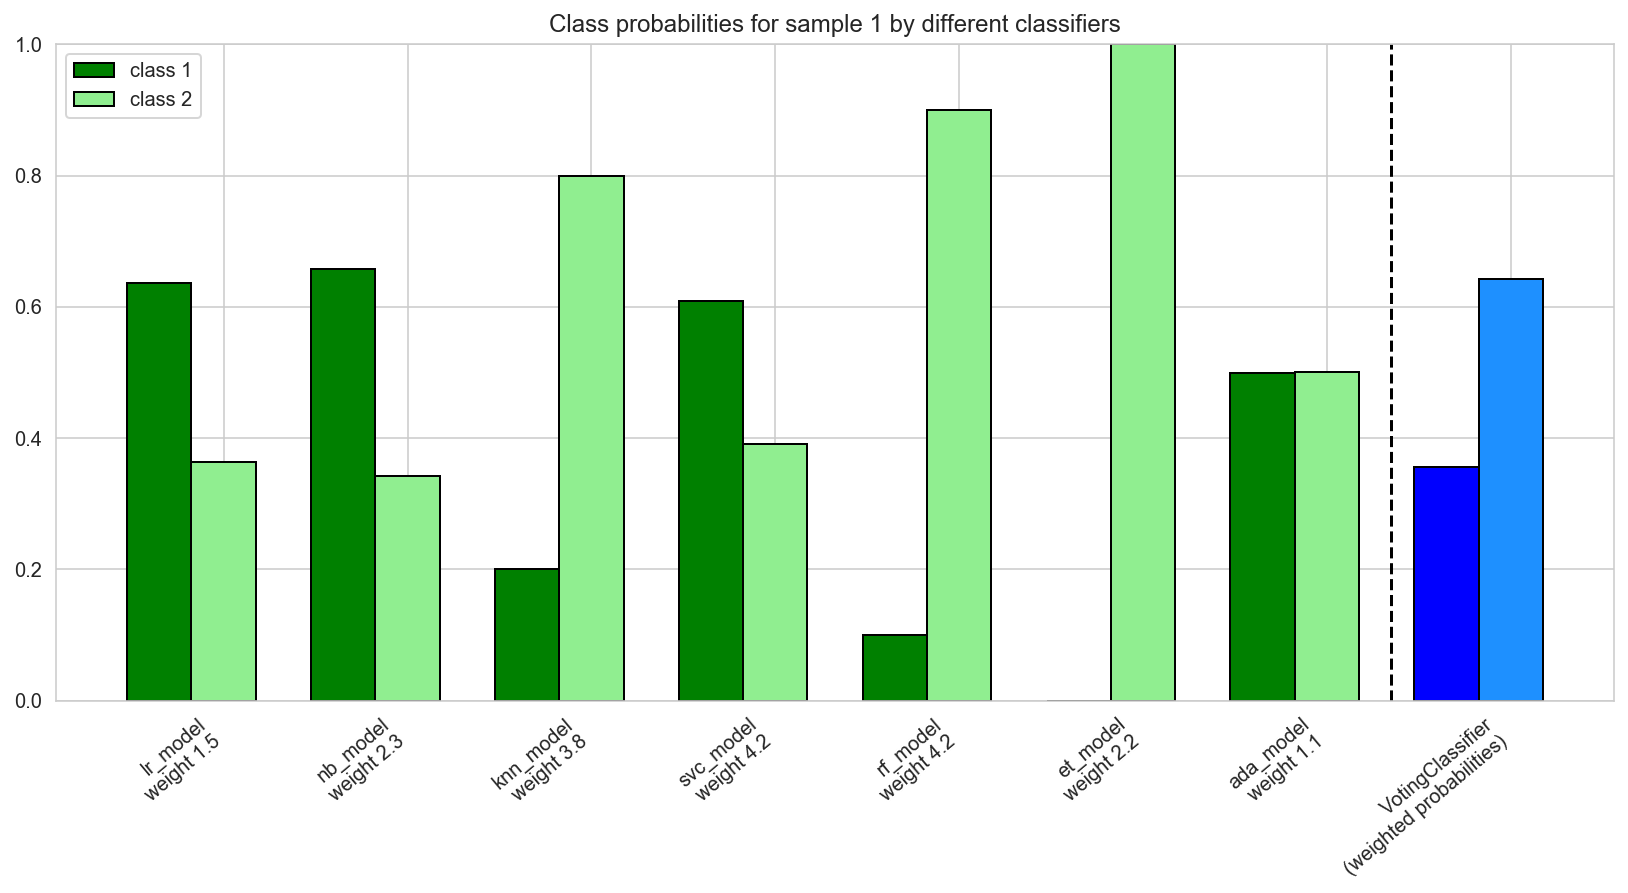

In [42]:
# plotting

N = 8  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-7
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), 
            width,
            color='green', 
            edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), 
            width,
            color='lightgreen', 
            edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0,0,0,0,0,0,0, class1_1[-1]], 
            width,
            color='blue', 
            edgecolor='k')
p4 = ax.bar(ind + width, [0,0,0,0,0,0,0, class2_1[-1]], 
            width,
            color='dodgerblue', 
            edgecolor='k')

# plot annotations
plt.axvline(N - 1.3, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
x_labels = [f"{n}\nweight {weights[i]}" for i, n in enumerate(model_names)]
ax.set_xticklabels(
    x_labels + ['VotingClassifier\n(weighted probabilities)'],
    rotation=40,
    ha='right')

plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.tight_layout()
plt.gcf().set_size_inches(12, 8)
plt.show()

## Tuning weights

In general, tuning the weights for the ensemble classifier is not easy. There is no built-in method to tune or even an educated guess as to where we begin our search. If this were a regression problem, we can take all of the outputs from each of the classifiers and pass them through an OLS model to tune each weight.

In our case, we have a classification problem which makes determining the right coefficients a little more difficult to do. One method is to use a **stacked classifier** which we will cover in the next section.

# Stacked Classifier

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. 

The individual classification models are trained based on the complete training set; then, the meta-classifier is fitted based on the outputs -- meta-features -- of the individual classification models in the ensemble. 

The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

The major difference between the Stacked Classifier and the Voting classifier, is that it uses the outputs of the previous models as features in the meta-classifier to make new predictions.

<img src="images/stacked.png" alt="" width="500" height="600"/>

In [43]:
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=BernoulliNB(), use_probas=False)

In [44]:
stacked.fit(X_train, y_train)

StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                                GaussianNB(priors=None, var_smoothing=1e-09),
                                KNeighborsClassif...
                                   

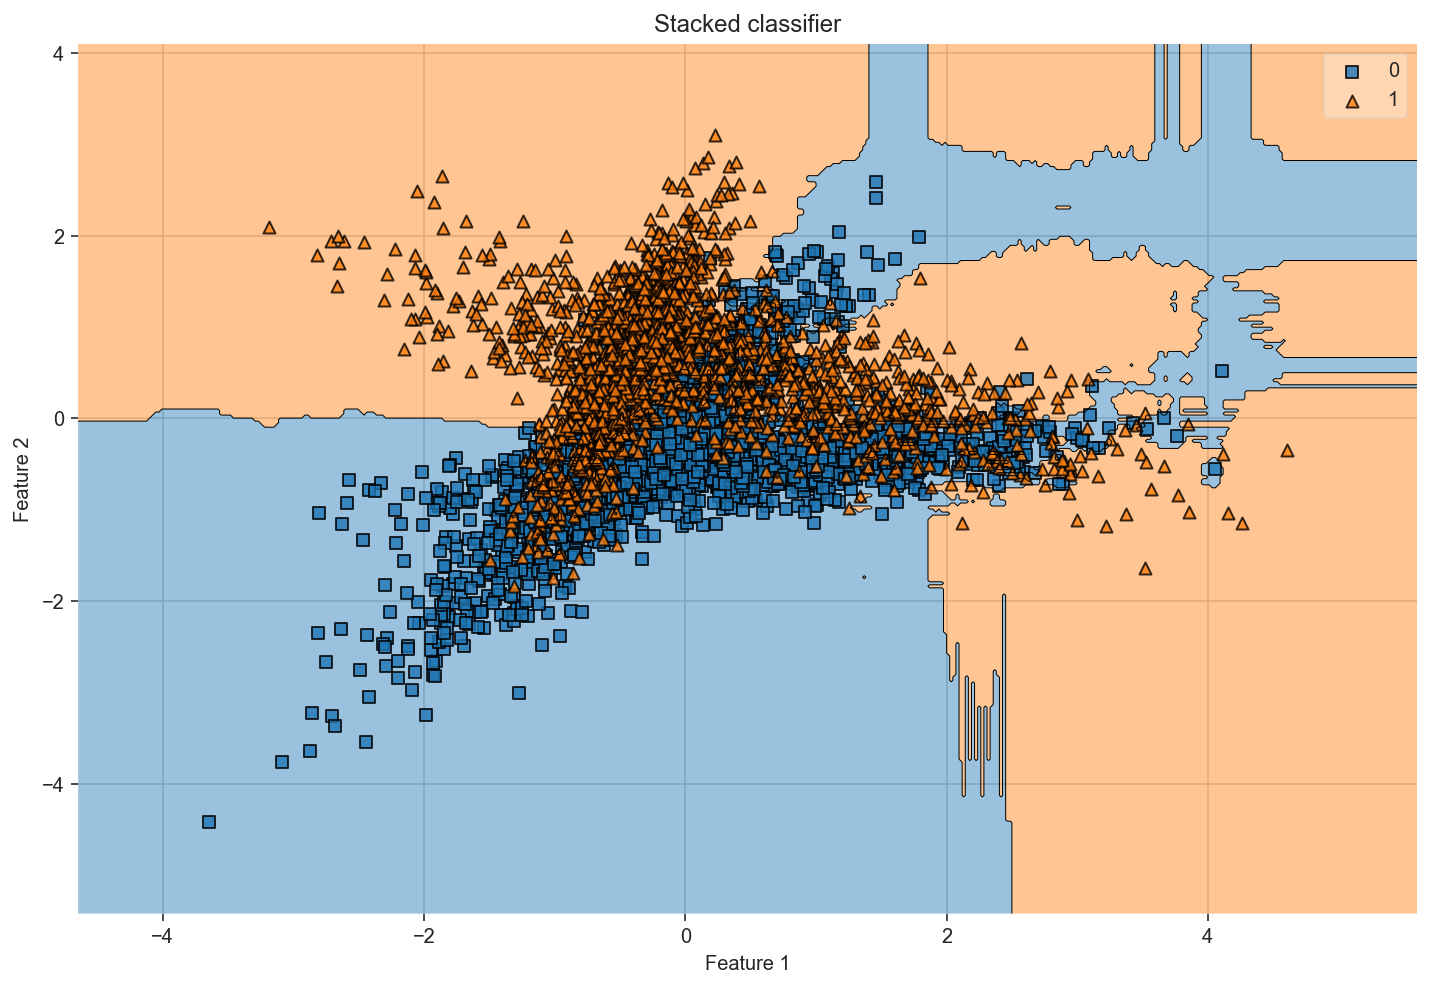

In [45]:
# Plot model
plot_decision_regions(X_train.values, y_train.values, stacked)
plt.title('Stacked classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

In [46]:
y_pred = stacked.predict(X_test)
accuracy_score(y_test, y_pred)  # Ensemble might be better, just a single model might be better.

0.8136

# Recap

![](images/ensemble-all-the-things.jpg)

In this lesson we covered the different techniques available to ensemble models in sklearn. 

Things to note:
- Max Voting returns the most common class out of the classifiers (similar to how KNN works)
- Average Voting returns the most likely class given all of the probabilities (similar to how Naive Bayes works)
- Weighted Voting returns the most likely class given the weighted sum of probabilities
- Finding the optimal weights to Weighted Voting can be difficult to achieve
- Stacked Classifiers use the outputs of the models as features into the meta-classifier

## Pros/Cons of Ensemble Methods

**Pros:**
- Reduces variance
- (generally) better model performance

**Cons:**
- Loss of model interpretability
- Possibility of high bias if data is not modeled properly
- Computationally expensive

# Resources
- http://people.csail.mit.edu/rivest/pubs/APR07.pdf
- http://www.mit.edu/~9.520/spring06/Classes/class10.pdf
- http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/
